## How to Approach

- Think like a producer not a consumer
- You have to know how to utilize a tool
  - Even if you can't understand perfectly
- In client's perspective, you have to know how to reduce a cost on their side.
- You have to know how to fit where you want to go in a single sentence
  - That is business oriented

- Compress the concept to keywords
  - Then consider for each concept, whether it will be solved in AI, personnel, or by system

- Lay down entire procedures in micro-details and consider which area could be automated.

## Background

This is the project for Section 3 from Code State.

The purpose of project is to determine the function of protein.
- The function of protein is determined by their structure and their docking site.
- Protein is composed of 20 types of amino acids.

### Approach
Using a proBERT, a NLP model which typically used in classifying text files,

### Goal
Predict the function of a set of proteins based on their amino acid sequences and other data

### Challenges:
Protein can have multiple function while interacting with other proteins.

## Load and install necessary libraries

In [ ]:
!pip install Bio
!pip install pyfastx
!pip install transformers
!pip install datasets
!pip install tf
!pip install tensorflow-addons
!pip install torchmetrics
!pip install tf-nightly
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import time
import os
import pyfastx
import Bio
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import datasets
import tensorflow as tf
import tensorflow_addons.metrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from google.colab import drive
from transformers import BertModel, BertTokenizer
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.14.0-dev20230515). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


## Load Data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_terms = pd.read_csv('/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_terms.tsv', sep = '\t')
train_tax = pd.read_csv('/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv', sep = '\t')
train_id = np.load('/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_ids.npy')

## Configuration

In [ ]:
class config:
  num_labels = 500
  batch_size = 8
  n_epochs = 10
  lr = 0.2

In [ ]:
config.num_labels

500

## Visualization

In [ ]:
# Create a unique label list
unique_labels = train_terms.term.unique()

In [ ]:
# Copy train FASTA to writable directory to build index later
#![ ! -f train_sequences.fasta ] && cp ../content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_sequences.fasta ./

`! -f` is a base code that check if the file exists and is a regular file.
- `!` negates the result of the test

In this code, it checks if the file train_sequences.fasta does not exist or is not a regular file and if it doesn’t exist or is not a regular file, it copies the file from …/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta to the current directory.

**Currently this code is not needed**

In [ ]:
# This will build an index file
train_fasta = pyfastx.Fasta('/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_sequences.fasta')
test_fasta = pyfastx.Fasta('/content/drive/MyDrive/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta')

In [ ]:
train_fasta

<Fasta> /content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_sequences.fasta contains 142246 sequences

In [ ]:
# Each fa[x].seq still does a disk queries so we avoid repeating them
# This will only make 140k queries instead of 5 millions (99.97% of them are duplicated)
seqs = {x: train_fasta[x].seq for x in train_terms['EntryID'].unique()}
train_terms['seq'] = train_terms['EntryID'].map(lambda x: seqs[x])

`seqs = {x: fa[x].seq for x in train['EntryID'].unique()}`
- The for x in train['EntryID'].unique() part is a loop that iterates over each unique 'EntryID' value, assigning it to the variable x.
- `{x: fa[x].seq}` is a key-value pair in the dictionary seqs. The key is x (the 'EntryID' value), and the value is `fa[x].seq` (the corresponding sequence).
  - `fa[x]` accesses the row of the fa dataframe that has an 'EntryID' value equal to x.
  - `fa[x].seq` returns the 'seq' value associated with that row.

`train['seq'] = train['EntryID'].map(lambda x: seqs[x])`
- use the `map()` method to the 'EntryID' column of the train dataframe, and uses a lambda function to look up each 'EntryID' value in the seqs dictionary and return the corresponding sequence.

In [ ]:
train_terms['seq']

0          MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
1          MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
2          MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
3          MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
4          MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
                                 ...                        
5363858    MDLIPSFSTETWLLLAISLVLLYLYGTYTHGIFRKLGIPGPTPLPF...
5363859    MDLIPSFSTETWLLLAISLVLLYLYGTYTHGIFRKLGIPGPTPLPF...
5363860    MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...
5363861    MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...
5363862    MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...
Name: seq, Length: 5363863, dtype: object

In [ ]:
train_terms.tail()

,EntryID,term,aspect,seq
5363858,X5L565,GO:0050649,MFO,MDLIPSFSTETWLLLAISLVLLYLYGTYTHGIFRKLGIPGPTPLPF...
5363859,X5L565,GO:0016491,MFO,MDLIPSFSTETWLLLAISLVLLYLYGTYTHGIFRKLGIPGPTPLPF...
5363860,X5M5N0,GO:0005515,MFO,MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...
5363861,X5M5N0,GO:0005488,MFO,MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...
5363862,X5M5N0,GO:0003674,MFO,MPDSITNGGRPPAPPSSVSSTTASTTGNFGTRRRLVNRIKKVDELH...


In [ ]:
train_terms['term'].nunique()

31466

In [ ]:
train_terms_selected = train_terms['term'].value_counts()[0: 1500].index.tolist()

In [ ]:
train_terms = train_terms[train_terms['term'].isin(train_terms_selected)]

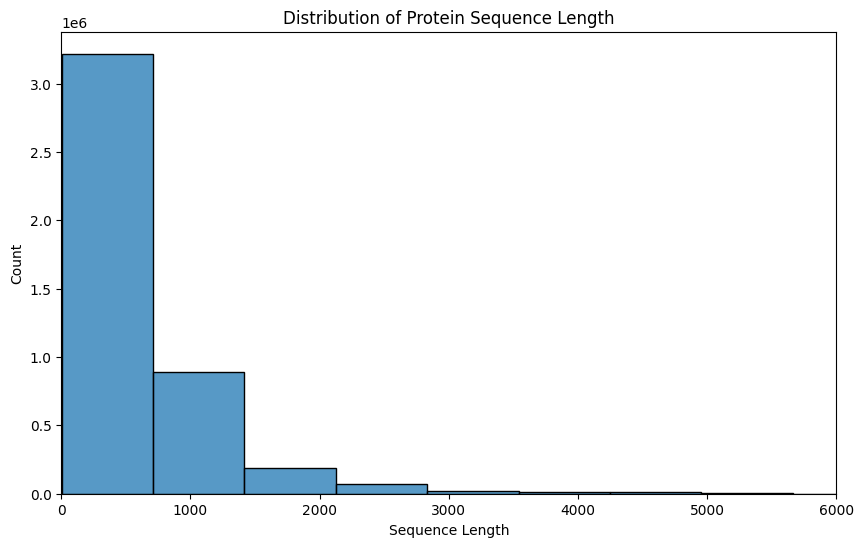

In [ ]:
# Check the length distribution of protein sequences

train_terms['seq_length'] = train_terms['seq'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_terms['seq_length'], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Length')
plt.xlim(0, 6000)
plt.show()

In [ ]:
train_terms['seq_length'].describe()

count    4.420737e+06
mean     6.327820e+02
std      7.695405e+02
min      3.000000e+00
25%      2.850000e+02
50%      4.610000e+02
75%      7.470000e+02
max      3.537500e+04
Name: seq_length, dtype: float64

## Tokenizing

In [ ]:
#sequence_example = "MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILGVTEAYKRDTNSKKMNLGVGAYRDDNGKPYVLPSVRKAEAQIAAKGLDKEYLPIGGLAEFCRASAELALGENSEVVKSGRFVTVQTISGTGALRIGASFLQRFFKFSRDVFLPKPSWGNHTPIFRDAGMQLQSYRYYDPKTCGFDFTGALEDISKIPEQSVLLLHACAHNPTGVDPRPEQWKEIATVVKKRNLFAFFDMAYQGFASGDGDKDAWAVRHFIEQGINVCLCQSYAKNMGLYGERVGAFTVICKDADEAKRVESQLKILIRPMYSNPPIHGARIASTILTSPDLRKQWLQEVKGMADRIIGMRTQLVSNLKKEGSTHSWQHITDQIGMFCFTGLKPEQVERLTKEFSIYMTKDGRISVAGVTSGNVGYLAHAIHQVTK"
#( len(sequence_example) )

#sequence_example = ' '.join(list(sequence_example)) # The tokenizer of prot_bert only accept white space splitted sequence.
#print(len(sequence_example))
#print((sequence_example))

#encoded_input = tokenizer(sequence_example, return_tensors='pt')
#output = model(**encoded_input)
#type(output) , output

### Attempt 4

```
def tokenize(sequences, length_limit):
  output = ' '.join(list(sequences))
  encoded_output = tokenizer(output, return_tensors='pt', padding='max_length', truncation=True, max_length = length_limit).to(device)
  return encoded_output
```

```
def embedding(encoded_input):
  output = model(**encoded_input)
  output_hidden = output['last_hidden_state'][:,0][0].detach().cpu().numpy()
  assert len(output_hidden)==1024
  return output
```

```
import numpy as np
import pandas as pd

def process_data(data):
  bert_embedded_vector = []
  checkpoint = 0
  ids_list = []
  df = pd.DataFrame(columns=["function_id", "bert_embedded_vector"])
  for item in data:
    ids_list.append(item.id)
    encoded_data = tokenize(sequences = item, length_limit = 1200)
    vectorized_data = embedding(encoded_data)
    bert_embedded_vector.append(vectorized_data)
    checkpoint+=1
    if checkpoint>=100:
      df_batch = pd.DataFrame(data={"id" : ids_list, "bert_embedded_vector": bert_embedded_vector})
      np.save('/content/drive/MyDrive/cafa-5-protein-function-prediction/train_ids.npy',np.array(ids_list))
      np.save('/content/drive/MyDrive/cafa-5-protein-function-prediction/train_embeddings.npy',np.array(bert_embedded_vector))
      df = pd.concat([df, df_batch], ignore_index=True)
      checkpoint = 0
  return df
```

```
train_df = process_data(train_fasta)
```

### Final Code

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


````
def get_bert_embedding(model, tokenizer, sequence, len_seq_limit):
    sequence_w_spaces = ' '.join(list(sequence))
    encoded_input = tokenizer.encode_plus(
        sequence_w_spaces,
        truncation=True,
        max_length=len_seq_limit,
        padding='max_length',
        return_tensors='pt'
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    output_hidden = output.last_hidden_state[:, 0, :].detach().cpu().numpy()
    assert output_hidden.shape[1] == 1024
    return output_hidden[0]

def process_sequences(sequences_path, output_dir, model, tokenizer, len_seq_limit):
    fasta_sequences = SeqIO.parse(sequences_path, "fasta")
    ids_list = []
    embed_vects_list = []
    t0 = time.time()
    checkpoint = 0
    for item in fasta_sequences:
        ids_list.append(item.id)
        embed_vects_list.append(
            get_bert_embedding(model, tokenizer, sequence=item.seq, len_seq_limit=len_seq_limit)
        )
        checkpoint += 1
        if checkpoint >= 100:
            df_res = pd.DataFrame(data={"id": ids_list, "embed_vect": embed_vects_list})
            np.save(os.path.join(output_dir, "ids.npy"), np.array(ids_list))
            np.save(os.path.join(output_dir, "embeddings.npy"), np.array(embed_vects_list))
            checkpoint = 0

    np.save(os.path.join(output_dir, "ids.npy"), np.array(ids_list))
    np.save(os.path.join(output_dir, "embeddings.npy"), np.array(embed_vects_list))
    print('Total Elapsed Time:', time.time() - t0)
````

````
# Process train set sequences
process_sequences(
    sequences_path="/content/drive/MyDrive/cafa-5-protein-function-prediction/Train/train_sequences.fasta",
    output_dir='/content/drive/MyDrive/cafa-5-protein-function-prediction/train/',
    model=model,
    tokenizer=tokenizer,
    len_seq_limit=1200
)
````

````
# Process test set sequences
process_sequences(
    sequences_path="/content/drive/MyDrive/cafa-5-protein-function-prediction/Test (Targets)/test_sequences.fasta",
    output_dir='/content/drive/MyDrive/cafa-5-protein-function-prediction/test/',
    model=model,
    tokenizer=tokenizer,
    len_seq_limit=1200
)
````

## Label train/test

```
def label_most_frequent_sequences(ids, labels):
  top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
  labels_names = top_terms[:config.num_labels].index.values
  train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
  id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()
  go_terms_map = {label: i for i, label in enumerate(labels_names)}
  labels_matrix = np.empty((len(ids), len(labels_names)))
  for index, id in enumerate(ids):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1
  np.save('/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_top' + str(config.num_labels) +'_labeled_sequence.npy', np.array(labels_matrix))
```

```
def label_most_frequent_sequences(ids, labels):
  top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
  labels_names = top_terms[:config.num_labels].index.values
  train_labels_sub = labels[(labels.term.isin(labels_names)) & (labels.EntryID.isin(ids))]
  id_labels = train_labels_sub.groupby('EntryID')['term'].apply(list).to_dict()
  go_terms_map = {label: i for i, label in enumerate(labels_names)}
  labels_matrix = np.empty((len(ids), len(labels_names)))
  for index, id in enumerate(ids):
    id_gos_list = id_labels[id]
    temp = [go_terms_map[go] for go in labels_names if go in id_gos_list]
    labels_matrix[index, temp] = 1
  np.save('/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_top' + str(config.num_labels) +'_labeled_sequence.npy', np.array(labels_matrix))

label_most_frequent_sequences(ids = train_id, labels = train_terms)
```

## Prepare Data

In [ ]:
train_embeds = np.load("/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_embeddings.npy")
train_ids = np.load("/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_ids.npy")
train_labels = np.load('/content/drive/MyDrive/cafa-5-protein-function-prediction/Embedded Data/train_top' + str(config.num_labels) +'_labeled_sequence.npy')

In [ ]:
train_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
embeds_list = []
for l in range(train_embeds.shape[0]):
  embeds_list.append(train_embeds[l, :])

labels_df = pd.DataFrame(train_labels, columns=range(train_labels.shape[1]))

train_df = pd.DataFrame(data={"EntryID": train_ids, "embed": embeds_list})
train_df = pd.concat([train_df, labels_df], axis=1)

In [ ]:
labels_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building a model

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, dilation=1, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, dilation=1, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, dilation=1, padding='same')
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(input_dim // 8 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

def train_model(train_embed, train_labels, val_embed, val_labels, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_embed = torch.tensor(train_embed, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.float32)
    val_embed = torch.tensor(val_embed, dtype=torch.float32)
    val_labels = torch.tensor(val_labels, dtype=torch.float32)

    train_dataset = TensorDataset(train_embed, train_labels)
    val_dataset = TensorDataset(val_embed, val_labels)

    train_size = len(train_dataset)
    val_size = len(val_dataset)

    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)

    model = CNN1D(input_dim=1024, num_classes=config.num_labels).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    metric1 = MultilabelF1Score(num_labels=config.num_labels, average='macro')
    loss_fn = nn.BCEWithLogitsLoss()
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_metric1_history = []
    train_loss_history = []
    val_metric1_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        model.train()
        train_metrics1 = []
        train_losses = []

        for embed, targets in train_dataloader:
            embed, targets = embed.to(device), targets.to(device)
            optimizer.zero_grad()
            logits = model(embed)
            loss_value = loss_fn(logits, targets)
            loss_value.backward()
            optimizer.step()

            train_metrics1.append(metric1(torch.sigmoid(logits), targets).detach().cpu().numpy())
            train_losses.append(loss_value.item())

        avg_train_metric1 = np.mean(train_metrics1)
        avg_train_loss = np.mean(train_losses)
        print("Running Average TRAIN F1 Score : ", avg_train_metric1)
        print("Running Average TRAIN Loss : ", avg_train_loss)
        train_metric1_history.append(avg_train_metric1)
        train_loss_history.append(avg_train_loss)

        ## VALIDATION PHASE :
        model.eval()
        val_metrics1 = []
        val_losses = []

        with torch.no_grad():
            for embed, targets in val_dataloader:
                embed, targets = embed.to(device), targets.to(device)
                logits = model(embed)
                loss_value = loss_fn(logits, targets)

                val_metrics1.append(metric1(torch.sigmoid(logits), targets).detach().cpu().numpy())
                val_losses.append(loss_value.item())

        avg_val_metric1 = np.mean(val_metrics1)
        avg_val_loss = np.mean(val_losses)
        print("Running Average VAL F1 Score : ", avg_val_metric1)
        print("Running Average VAL Loss : ", avg_val_loss)
        val_metric1_history.append(avg_val_metric1)
        val_loss_history.append(avg_val_loss)

        scheduler.step(avg_val_metric1)

    print("TRAINING FINISHED")
    print("FINAL TRAINING")

    metrics_history = {"train_f1_score": train_metric1_history, "train_loss": train_loss_history,
                       "val_f1_score": val_metric1_history, "val_loss": val_loss_history}

    return model, metrics_history


## Train

In [ ]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.25, random_state=42)

# Convert the input data and labels to NumPy arrays
train_embed = np.array(train_data["embed"].tolist())
train_labels = np.array(train_data.drop(["EntryID", "embed"], axis=1))

val_embed = np.array(val_data["embed"].tolist())
val_labels = np.array(val_data.drop(["EntryID", "embed"], axis=1))

In [ ]:
train_labels

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
model, metrics_history = train_model(train_embed, train_labels, val_embed, val_labels, config)

BEGIN TRAINING...
EPOCH  1
Running Average TRAIN F1 Score :  0.0069602057
Running Average TRAIN Loss :  0.5698480818132369
Running Average VAL F1 Score :  0.008162505
Running Average VAL Loss :  0.16720495131193547
EPOCH  2
Running Average TRAIN F1 Score :  0.0069087096
Running Average TRAIN Loss :  0.1673099726268683
Running Average VAL F1 Score :  0.008391905
Running Average VAL Loss :  0.1680965070259555
EPOCH  3
Running Average TRAIN F1 Score :  0.006896006
Running Average TRAIN Loss :  0.16732167077307206
Running Average VAL F1 Score :  0.0060049375
Running Average VAL Loss :  0.16732695289844335
EPOCH  4
Running Average TRAIN F1 Score :  0.0069229337
Running Average TRAIN Loss :  0.16730288166081256
Running Average VAL F1 Score :  0.0060049375
Running Average VAL Loss :  0.16618377812042517
EPOCH  5


KeyboardInterrupt: ignored